In [1]:
!pip install torchmetrics
!pip install thop
!pip install yacs
!pip install kornia
!pip install torch torchvision thop opencv-python tqdm numpy scipy

In [3]:
#import

import zipfile
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
from PIL import Image
import os
from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
from thop import profile, clever_format

import torch.nn as nn
import torch.optim as optim

from torchmetrics import JaccardIndex
import torch.nn.functional as F
import random

from tqdm import tqdm

import kornia
import time
import logging
from torch.utils import data, model_zoo



import argparse
import torch
import torch.nn as nn
from torch.utils import data, model_zoo
import numpy as np
import pickle
from torch.autograd import Variable
import torch.optim as optim
import scipy.misc
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import sys
import os
import os.path as osp
import matplotlib.pyplot as plt
import random

In [4]:
!wget https://zenodo.org/record/5706578/files/Train.zip
!wget https://zenodo.org/record/5706578/files/Val.zip

--2025-01-20 13:39:22--  https://zenodo.org/record/5706578/files/Train.zip
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/5706578/files/Train.zip [following]
--2025-01-20 13:39:23--  https://zenodo.org/records/5706578/files/Train.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 4021669263 (3.7G) [application/octet-stream]
Saving to: ‘Train.zip’

Train.zip           100%[===================>]   3.75G  13.2MB/s    in 4m 58s  

2025-01-20 13:44:21 (12.9 MB/s) - ‘Train.zip’ saved [4021669263/4021669263]

--2025-01-20 13:44:21--  https://zenodo.org/record/5706578/files/Val.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request 

In [5]:
!wget https://zenodo.org/records/14606189/files/PIDNet_S_ImageNet.pth.tar

--2025-01-20 13:46:23--  https://zenodo.org/records/14606189/files/PIDNet_S_ImageNet.pth.tar
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38061375 (36M) [application/octet-stream]
Saving to: ‘PIDNet_S_ImageNet.pth.tar’

PIDNet_S_ImageNet.p 100%[===================>]  36.30M  11.9MB/s    in 3.2s    

2025-01-20 13:46:27 (11.2 MB/s) - ‘PIDNet_S_ImageNet.pth.tar’ saved [38061375/38061375]



In [6]:
# Define file paths
train_zip = "Train.zip"
val_zip = "Val.zip"

# Extract Train.zip
with zipfile.ZipFile(train_zip, 'r') as zip_ref:
    zip_ref.extractall("Train")

# Extract Val.zip
with zipfile.ZipFile(val_zip, 'r') as zip_ref:
    zip_ref.extractall("Val")

# Verify the extracted folders
print("Train Directory Contents:", os.listdir("Train"))
print("Val Directory Contents:", os.listdir("Val"))

Train Directory Contents: ['Train']
Val Directory Contents: ['Val']


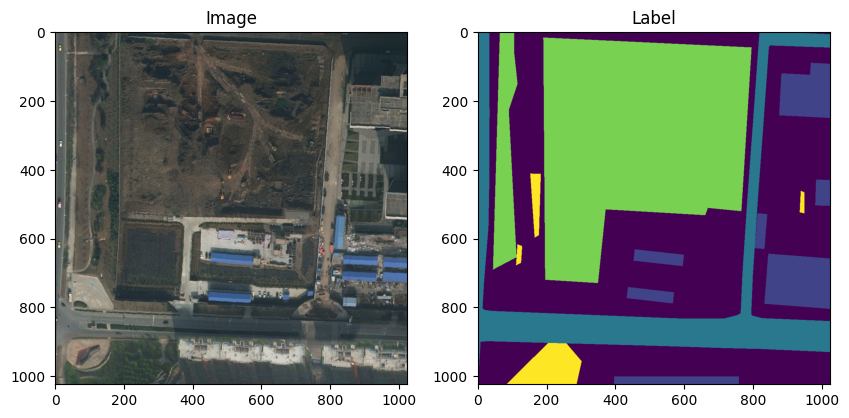

In [7]:
# Load and visualize an image and its corresponding label
image_path = "Train/Train/Urban/images_png/1366.png"
label_path = "Train/Train/Urban/masks_png/1366.png"

image = Image.open(image_path)
label = Image.open(label_path)

# Display
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.title("Label")
plt.imshow(label)
plt.show()

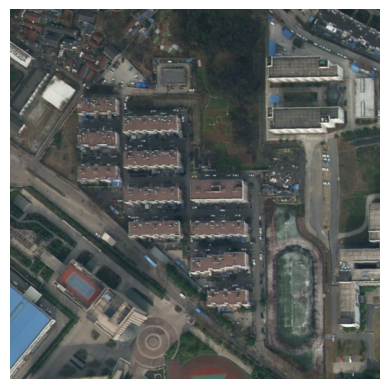

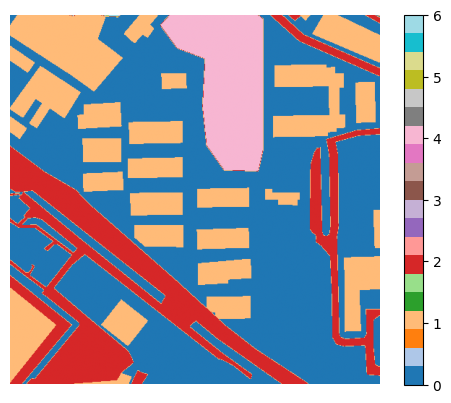

In [8]:
#TASK 5

COLOR_MAP = {
    'Background': 0.00392157,
    'Building': 0.00784314,
    'Road': 0.01176471,
    'Water': 0.01568628,
    'Barren': 0.01960784,
    'Forest': 0.02352941,
    'Agricultural': 0.02745098
}

LABEL_MAP = OrderedDict(
    Background=0,
    Building=1,
    Road=2,
    Water=3,
    Barren=4,
    Forest=5,
    Agricultural=6
)

# Tolerance-based color to label conversion
def color_to_one_hot(mask, label_map, tolerance=0.001, num_classes=7):
    mask = np.asarray(mask, dtype=np.float32)
    if len(mask.shape) == 2:  # Ensure channel dimension exists
        mask = np.expand_dims(mask, axis=0)  # Convert [H, W] to [1, H, W]

    one_hot_mask = np.zeros((num_classes, mask.shape[1], mask.shape[2]), dtype=np.float32)

    for class_name, class_index in label_map.items():
        color_value = COLOR_MAP[class_name]
        # Match pixels with the grayscale value within the tolerance
        matches = np.abs(mask - color_value) < tolerance
        one_hot_mask[class_index, np.squeeze(matches, axis=0)] = 1.0

    return torch.from_numpy(one_hot_mask)


# Define a function to denormalize the image
def denormalize(tensor, mean, std):
    """ Denormalize the tensor back to the [0, 1] range for visualization. """
    for i in range(len(mean)):
        tensor[i] = tensor[i] * std[i] + mean[i]
    return tensor

def show_image(image_tensor):
    """ Display a transformed image using matplotlib. """
    image_tensor = denormalize(image_tensor, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Denormalize the image
    image = image_tensor.permute(1, 2, 0).numpy()  # Convert to HxWxC format
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

def show_mask(mask_tensor, num_classes=7):
    """ Display the mask using matplotlib. """
    # Convert the one-hot mask to the label mask (indices of the highest value per pixel)
    mask = mask_tensor.squeeze().cpu().numpy()  # Remove the batch dimension and convert to numpy
    label_mask = np.argmax(mask, axis=0)  # Get the class index with the highest value for each pixel

    plt.imshow(label_mask, cmap='tab20')  # Use a colormap suitable for categorical data
    plt.colorbar()  # Optionally add a color bar
    plt.axis('off')  # Hide axes
    plt.show()


def colorJitter(colorJitter, img_mean, data = None, target = None, s=0.25):
    # s is the strength of colorjitter
    #colorJitter
    if not (data is None):
        if data.shape[1]==3:
            if colorJitter > 0.2:
                img_mean, _ = torch.broadcast_tensors(img_mean.unsqueeze(0).unsqueeze(2).unsqueeze(3), data)
                seq = nn.Sequential(kornia.augmentation.ColorJitter(brightness=s,contrast=s,saturation=s,hue=s))
                data = (data+img_mean)/255
                data = seq(data)
                data = (data*255-img_mean).float()
    return data, target

def gaussian_blur(blur, data = None, target = None):
    if not (data is None):
        if data.shape[1]==3:
            if blur > 0.5:
                sigma = np.random.uniform(0.15,1.15)
                kernel_size_y = int(np.floor(np.ceil(0.1 * data.shape[2]) - 0.5 + np.ceil(0.1 * data.shape[2]) % 2))
                kernel_size_x = int(np.floor(np.ceil(0.1 * data.shape[3]) - 0.5 + np.ceil(0.1 * data.shape[3]) % 2))
                kernel_size = (kernel_size_y, kernel_size_x)
                seq = nn.Sequential(kornia.filters.GaussianBlur2d(kernel_size=kernel_size, sigma=(sigma, sigma)))
                data = seq(data)
    return data, target

def strongTransform(parameters, data=None, target=None):
    assert ((data is not None) or (target is not None))
    # data, target = transformsgpu.oneMix(mask = parameters["Mix"], data = data, target = target)
    data, target = colorJitter(colorJitter = parameters["ColorJitter"], img_mean = torch.from_numpy(IMG_MEAN.copy()).cuda(), data = data, target = target)
    data, target = gaussian_blur(blur = parameters["GaussianBlur"], data = data, target = target)
    # data, target = transformsgpu.flip(flip = parameters["flip"], data = data, target = target)
    return data, target



class LoveDADataset(Dataset):
    def __init__(self, root_dir, split='train', transform_image=None, transform_label=None, subdir="Rural", aug1=False, aug2=False):
        self.root_dir = root_dir
        self.split = split
        self.transform_image = transform_image
        self.transform_label = transform_label
        self.aug1 = aug1
        self.aug2 = aug2
        self.image_paths = []
        self.label_paths = []

        image_dir = os.path.join(root_dir, split, subdir, 'images_png')
        label_dir = os.path.join(root_dir, split, subdir, 'masks_png')

        for f in os.listdir(image_dir):
            if f.endswith('.png'):
                self.image_paths.append(os.path.join(image_dir, f))
                self.label_paths.append(os.path.join(label_dir, f))

    def __len__(self):
        original_length = len(self.image_paths)
        if self.aug1 and self.aug2:
            return original_length * 2
        elif self.aug1 or self.aug2:
            return int(original_length * 1.5)
        else:
            return original_length


    def __getitem__(self, idx):
        original_length = len(self.image_paths)

        # Calcola l'indice originale nel dataset
        idx = idx % original_length

        aug_1 = False
        aug_2 = False
        if(idx < original_length):
            aug_1 = False
            aug_2 = False

        elif(idx >= original_length):
            if(random.random() < 0.5):
                if(self.aug1):
                    aug_1 = True
                    aug_2 = False
                elif(self.aug2):
                    aug_1 = False
                    aug_2 = True

            else:
                if (self.aug2):
                    aug_1 = False
                    aug_2 = True
                elif(self.aug1):
                    aug_1 = True
                    aug_2 = False



        # Carica l'immagine e la maschera
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = Image.open(self.label_paths[idx]).convert("L")

        image_np = np.array(image)
        label_np = np.array(label)

        # Seed per garantire coerenza tra immagine e maschera
        seed = np.random.randint(2147483647)

        # Applica augmentazione se abilitata
        if self.aug1 and aug_1:
            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            transform_aug1 = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(30)
            ])
            image = Image.fromarray(image_np)
            image = transform_aug1(image)
            image_np = np.array(image)

            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            label = Image.fromarray(label_np)
            label = transform_aug1(label)
            label_np = np.array(label)

        if self.aug2 and aug_2:
            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)

            strong_parameters = {}
            strong_parameters["ColorJitter"] = random.uniform(0, 1)
            strong_parameters["GaussianBlur"] = random.uniform(0, 1)


            image = Image.fromarray(image_np)
            image, _ = strongTransform(strong_parameters, image, None)
            image_np = np.array(image)

            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            label = Image.fromarray(label_np)
            # label = transform_aug2(label)
            label_np = np.array(label)

        # Trasformazioni opzionali per immagine e maschera
        if self.transform_image:
            transform_image_alb = transforms.Compose([
                transforms.Resize((512, 512)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            image = Image.fromarray(image_np)
            image = transform_image_alb(image)

        if self.transform_label:
            transform_label_alb = transforms.Compose([
                transforms.Resize((512, 512)),
                transforms.ToTensor()
            ])
            label = Image.fromarray(label_np)
            label = transform_label_alb(label).squeeze(0)
            label = color_to_one_hot(label, LABEL_MAP)

        return image,label

# Define transformations without augmentations
transform_image = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

transform_label = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Set augmentation flags
AUG1 = True
AUG2 = True

BATCH_SIZE = 16 #or 32, or 64 ...
NUM_WORKERS = 2 # Number of cpu cores
PIN_MEMORY = True
PERSISTENT_WORKERS = False # Set true if you have persistent workers issues
# Create dataset and dataloader with augmentations
train_dataset = LoveDADataset(root_dir='Train/', split='Train', transform_image=transform_image, transform_label=transform_label, subdir='Urban', aug1=AUG1, aug2=AUG2)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=PERSISTENT_WORKERS)
val_dataset = LoveDADataset(root_dir='Val/', split='Val', transform_image=transform_image, transform_label=transform_label, subdir='Urban')




val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

target_dataset = LoveDADataset(root_dir='Train/', split='Train', transform_image=transform_image, transform_label=transform_label, subdir='Rural')
target_loader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

# Visualize the first batch of images
for i, (image, label) in enumerate(train_loader):
    if i == 0:  # Show only the first batch
        show_image(image[0])  # Access the first image of the batch
        show_mask(label[0])
        break


# # Definisci una dimensione più piccola per il subset (ad esempio 10% del dataset)
# subset_size = 200  # Usa solo i primi 100 campioni per il test

# # Usa torch.utils.data.Subset per ottenere un subset casuale dei dati
# subset_indices = torch.randperm(len(train_loader.dataset)).tolist()[:subset_size]

# train_subset = torch.utils.data.Subset(train_loader.dataset, subset_indices)

# target_subset= torch.utils.data.Subset(target_loader.dataset, subset_indices)

# val_subset= torch.utils.data.Subset(val_loader.dataset, subset_indices)

# # Crea un DataLoader per il subset
# train_subset_loader = DataLoader(train_subset, batch_size=2, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=PERSISTENT_WORKERS)

# target_subset_loader = DataLoader(target_subset, batch_size=2, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=PERSISTENT_WORKERS)

# val_subset_loader = DataLoader(val_subset, batch_size=2, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=PERSISTENT_WORKERS)



# for i, (image, label) in enumerate(train_subset_loader):
#     if i == 0:  # Show only the first batch
#         show_image(image[0])  # Access the first image of the batch
#         show_mask(label[0])
#         break


# target_loader=target_subset_loader

# val_loader=val_subset_loader

# train_loader=train_subset_loader

Visualizing image 1


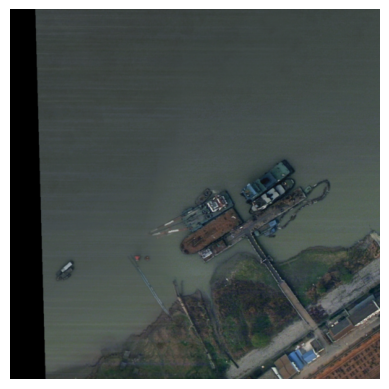

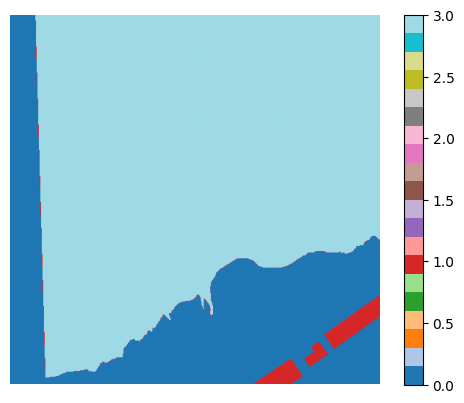

In [9]:
# Funzione per visualizzare immagini con augmentations applicate
def visualize_augmented_images(dataloader, num_images=1):
    """
    Visualizza immagini con augmentations applicate.
    Args:
        dataloader: Il DataLoader dal quale prelevare le immagini.
        num_images: Numero di immagini da visualizzare.
    """
    count = 0
    for images, labels in dataloader:
        for i in range(images.size(0)):
            if count >= num_images:
                return  # Mostra solo il numero richiesto di immagini
            print(f"Visualizing image {count + 1}")
            show_image(images[i])  # Visualizza l'immagine
            show_mask(labels[i])  # Visualizza la maschera
            count += 1

# Visualizza immagini con augmentations dal train_loader
visualize_augmented_images(train_loader, num_images=1)

In [10]:
!git clone https://github.com/XuJiacong/PIDNet.git
%cd content

Cloning into 'PIDNet'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 386 (delta 131), reused 125 (delta 125), pack-reused 193 (from 1)
Receiving objects: 100% (386/386), 212.80 MiB | 21.19 MiB/s, done.
Resolving deltas: 100% (184/184), done.
[Errno 2] No such file or directory: 'content'
/content


In [11]:
import sys
sys.path.append('/content/PIDNet')

In [12]:
from models.model_utils import BasicBlock, Bottleneck, segmenthead, DAPPM, PAPPM, PagFM, Bag, Light_Bag
from utils.criterion import CrossEntropy, OhemCrossEntropy, BondaryLoss

In [13]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [14]:
#BISENET
# cloning github repo for model (BiseNet with STDC) and utils, I rewrote manually the Train.py and Cityscapes.py below
import pathlib
print(pathlib.Path.cwd())
!git clone https://github.com/ivanmag22/Semantic_Segmentation_project.git


# importing stuff from the repo we just cloned
from Semantic_Segmentation_project.model.model_stages import BiSeNet
from Semantic_Segmentation_project.model.bisenetv1 import BiSeNet as BiSeNetv1


/content
Cloning into 'Semantic_Segmentation_project'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 104 (delta 14), reused 31 (delta 11), pack-reused 70 (from 1)
Receiving objects: 100% (104/104), 221.77 MiB | 38.10 MiB/s, done.
Resolving deltas: 100% (47/47), done.
Updating files: 100% (12/12), done.


In [15]:
model_name = 'STDC-net'
pretrain = "/content/Semantic_Segmentation_project/model/best_models/p4_bisenetv1_domadpt_lightdiscr_BSv1_Best_model_epoch_25.pth"
if model_name == 'STDC-ne':
    backbone='CatmodelSmall'
    model = BiSeNet(backbone=backbone, n_classes=7, pretrain_model=pretrain, use_conv_last=False, device=device)
else:
    backbone='resnet18'
    model = BiSeNetv1(num_classes=7, context_path=backbone)
    # model.load_state_dict(torch.load(pretrain), strict=False)
# device = t
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 88.6MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed 

BiSeNet(
  (saptial_path): Spatial_path(
    (convblock1): ConvBlock(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (convblock2): ConvBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (convblock3): ConvBlock(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
  )
  (context_path): ResNet18(
    (features): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [16]:
!git clone https://github.com/wasidennis/AdaptSegNet.git
sys.path.append('/content/AdaptSegNet')

Cloning into 'AdaptSegNet'...
remote: Enumerating objects: 281, done.
remote: Total 281 (delta 0), reused 0 (delta 0), pack-reused 281 (from 1)
Receiving objects: 100% (281/281), 2.98 MiB | 7.36 MiB/s, done.
Resolving deltas: 100% (146/146), done.


In [17]:
from model.discriminator import FCDiscriminator
from dataset.gta5_dataset import GTA5DataSet
from dataset.cityscapes_dataset import cityscapesDataSet
from utils.criterion import CrossEntropy, OhemCrossEntropy, BondaryLoss

In [18]:

num_classes=7
# LEARNING_RATE_D = 1e-4
learning_rate_D = 5e-4


bce_loss = torch.nn.BCEWithLogitsLoss()

model_D1 = FCDiscriminator(num_classes=num_classes)
optimizer_D1 = optim.Adam(model_D1.parameters(), lr=learning_rate_D, betas=(0.9, 0.99))
optimizer_D1.zero_grad()

model_D1.train()
model_D1.cuda(device)

FCDiscriminator(
  (conv1): Conv2d(7, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (classifier): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (leaky_relu): LeakyReLU(negative_slope=0.2, inplace=True)
)

In [19]:

# per sicurezza

learning_rate = 0.001

# model = get_seg_model(name='pidnet_s', num_classes=7, imgnet_pretrained=True, model_pth='PIDNet_S_ImageNet.pth.tar').to(device)


# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # You can adjust the learning rate

# random - experience
class_weights = torch.FloatTensor([0.8373, 0.918, 0.866, 1.0345,
                                        1.0166, 0.9969, 0.9754]).cuda()

# Define the loss function
# criterion = nn.CrossEntropyLoss()
criterion = OhemCrossEntropy(ignore_label=255,
                                        thres=0.9,
                                        min_kept=131072,
                                        weight=class_weights)

# Define mIoU metric
jaccard = JaccardIndex(task="multiclass", num_classes=7).to('cuda')  # intersection over union. Directly measures the overlap between predicted segmentation and ground truth.


# Training loop
num_epochs = 20 #20
best_miou = 0.0

lambda_adv_1 = 0.001

def poly_lr_scheduler(optimizer, init_lr, iter, lr_decay_iter=1,  max_iter=300, power=0.9):
    """Polynomial decay of learning rate
    :param init_lr is base learning rate
    :param iter is a current iteration
    :param lr_decay_iter how frequently decay occurs, default is 1
    :param max_iter is number of maximum iterations
    :param power is a polymomial power

    """
    # if iter % lr_decay_iter or iter > max_iter:
    # 	return optimizer

    lr = init_lr*(1 - iter/max_iter)**power
    optimizer.param_groups[0]['lr'] = lr
    return lr
    # return lr



def evaluate(images,masks):
    val_miou = 0.0
    val_class_iou = torch.zeros(len(LABEL_MAP)).to('cuda')  # Store IoU per class
    val_class_counts = torch.zeros(len(LABEL_MAP)).to('cuda')  # To track number of pixels for each class

    images, masks = images.to('cuda'), masks.to('cuda')

    # Forward pass
    outputs = model(images)  # [batch_size, num_classes, 64, 64]
    main_output = outputs
    preds = torch.argmax(main_output, dim=1)  # [batch_size, 64, 64]

    # Convert masks to class indices format if one-hot encoded
    if masks.ndim == 4:  # [batch_size, num_classes, height, width]
        masks = masks.argmax(dim=1)  # [batch_size, height, width]

    # # Resize preds to match the size of the masks
    # print(preds.shape)
    # print(masks.shape)

    preds_resized = F.interpolate(preds.unsqueeze(1).float(), size=masks.shape[1:], mode='nearest').squeeze(1).long()

    # Calculate per-class IoU
    for c, class_name in LABEL_MAP.items():  # Iterate over LABEL_MAP classes
        true_class = (masks == class_name)
        pred_class = (preds_resized == class_name)

        intersection = torch.sum(true_class & pred_class).float()
        union = torch.sum(true_class | pred_class).float()

        if union != 0:
            val_class_iou[class_name] += intersection / union
        val_class_counts[class_name] += 1

    # Calculate overall mIoU for this batch
    val_miou += jaccard(preds_resized, masks)

    return val_miou,val_class_iou



for epoch in range(num_epochs):
    model.train()
    model_D1.train()
    running_loss = 0.0
    counter = 0
    loss_D_epoch = 0

    loss_A_epoch = 0

    lr = poly_lr_scheduler(optimizer, learning_rate, iter=epoch, max_iter=20)
    lr_discriminator = poly_lr_scheduler(optimizer_D1, learning_rate_D, iter=epoch, max_iter=20)
    softmaxt = True

    train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") # train_loader
    for images, masks in train_progress_bar:
        images, masks = images.to(device), masks.to(device)




        for param in model_D1.parameters():
                param.requires_grad = False


        try:
          target_images, _ = next(val_l)  # Get target domain data
          target_images = target_images.to('cuda')
        except:

          val_l = iter(target_loader)
          target_images, _ = next(val_l)  # Get target domain data
          target_images = target_images.to('cuda')


        optimizer.zero_grad()
        optimizer_D1.zero_grad()

        # How to use softmax output_discriminator = model_D(F.softmax(output_target, dim=1))
        # 0 train segmentation net
        masks = masks.argmax(dim=1)
        outputs = model(images)  # Main segmentation output
        outputs_resized = F.interpolate(outputs[0], size=masks.shape[1:], mode='bilinear', align_corners=False)
        seg_loss = criterion(outputs_resized, masks)
        seg_loss.backward()


        # Adversarial loss for target domain
        outputs_target = model(target_images) # Main segmentation output for target
        outputs_target_resized = F.interpolate(outputs_target[0], size=masks.shape[1:], mode='bilinear', align_corners=False)
        out_t = outputs_target_resized
        if softmaxt== True:
            out_t = F.softmax(out_t, dim=1)
        D_out_target_adv = model_D1((out_t))

        adv_loss = bce_loss(D_out_target_adv, torch.ones_like(D_out_target_adv)) * lambda_adv_1

        loss_A_epoch+=adv_loss

        adv_loss.backward()

        # 1. Train Discriminator

        # bring back requires_grad
        for param in model_D1.parameters():
            param.requires_grad = True


        # Forward pass for source domain
        out_s = (outputs_resized.detach())
        if softmaxt== True:
            out_s = F.softmax(out_s, dim=1)
        D_out_source = model_D1(out_s)
        D_loss_source = bce_loss((D_out_source), torch.ones_like(D_out_source))  # Label 1 for source
        loss_D_epoch += D_loss_source.item()
        D_loss_source.backward()

        # Forward pass for target domain

        out_t = outputs_target_resized.detach()
        if softmaxt== True:
            out_t = F.softmax(out_t, dim=1)
        D_out_target = model_D1(out_t)
        D_loss_target = bce_loss((D_out_target), torch.zeros_like(D_out_target))  # Label 0 for target
        loss_D_epoch += D_loss_target.item()
        D_loss_target.backward()

        optimizer_D1.step()
        optimizer.step()


        counter+=1
        # adjust_learning_rate(optimizer, counter)
        # adjust_learning_rate_D(optimizer_D1, counter)


        running_loss += seg_loss.item()

        # Update tqdm progress bar with real-time loss using set_postfix
        train_progress_bar.set_postfix({
          "seg_loss": f"{seg_loss.item():.4f}",
          "adv_loss": f"{adv_loss:.4f}",
          "D_loss": f"{(D_loss_source.item() + D_loss_target.item()):.4f}",
          "lr": f"{optimizer.param_groups[0]['lr']:.4f}",
          "lr_D": f"{optimizer_D1.param_groups[0]['lr']:.4f}"
        })

    avg_loss = running_loss / len(train_loader) #len(train_subset_loader) #len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}] Seg _ Loss: {avg_loss:.4f}")
    print(f"Epoch [{epoch + 1}/{num_epochs}] Adv _ Loss: {loss_A_epoch/len(train_loader):.4f}")
    print(f"Epoch [{epoch + 1}/{num_epochs}]  Disc _ Loss: {loss_D_epoch/len(train_loader):.4f}")


    # Clear GPU memory
    torch.cuda.empty_cache()

    # Validation loop
    model.eval()
    val_miou = 0.0
    target_val_miou = 0.0
    val_class_iou = torch.zeros(len(LABEL_MAP)).to('cuda')  # Store IoU per class
    val_class_counts = torch.zeros(len(LABEL_MAP)).to('cuda')  # To track number of pixels for each class

    with torch.no_grad():
        for images, masks in tqdm(val_loader):
            miou, val_class_iou= evaluate(images,masks)
            val_miou += miou

    with torch.no_grad():
        for images, masks in tqdm(target_loader):
            miou, target_class_iou= evaluate(images,masks)

            target_val_miou += miou


    # Average metrics
    val_miou /= len(val_loader)

    # Calculate average IoU for each class
    avg_class_iou = val_class_iou / val_class_counts
    target_miou= target_val_miou / len(target_loader)

    # Print validation metrics at the end of each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - Validation mIoU: {val_miou:.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}] - Target mIoU: {target_miou:.4f}")



    print(f"Epoch [{epoch+1}/{num_epochs}] - Per-Class IoU: {dict(zip(LABEL_MAP.keys(), target_class_iou.tolist()))}")

    # Save the best model
    if target_miou > best_miou:
        best_miou = target_miou
        torch.save(model.state_dict(), 'best_pidnet_model.pth')

print(f"Best Validation mIoU: {best_miou:.4f}")


Epoch 1/20: 100%|██████████| 145/145 [06:52<00:00,  2.84s/batch, seg_loss=0.4121, adv_loss=0.0008, D_loss=1.3735, lr=0.0010, lr_D=0.0005]


Epoch [1/20] Seg _ Loss: 0.5244
Epoch [1/20] Adv _ Loss: 0.0007
Epoch [1/20]  Disc _ Loss: 1.3726


100%|██████████| 86/86 [01:49<00:00,  1.27s/it]


Epoch [1/20] - Validation mIoU: 0.1677
Epoch [1/20] - Target mIoU: 0.1176
Epoch [1/20] - Per-Class IoU: {'Background': 0.4605250060558319, 'Building': 0.12772253155708313, 'Road': 0.07838506251573563, 'Water': 0.0, 'Barren': 0.0002626360801514238, 'Forest': 0.07585423439741135, 'Agricultural': 0.023581059649586678}


Epoch 2/20: 100%|██████████| 145/145 [06:52<00:00,  2.85s/batch, seg_loss=0.4158, adv_loss=0.0009, D_loss=1.2146, lr=0.0010, lr_D=0.0005]


Epoch [2/20] Seg _ Loss: 0.4181
Epoch [2/20] Adv _ Loss: 0.0009
Epoch [2/20]  Disc _ Loss: 1.3048


100%|██████████| 86/86 [01:53<00:00,  1.32s/it]


Epoch [2/20] - Validation mIoU: 0.2405
Epoch [2/20] - Target mIoU: 0.2189
Epoch [2/20] - Per-Class IoU: {'Background': 0.15254101157188416, 'Building': 0.32671481370925903, 'Road': 0.08908122032880783, 'Water': 0.2759266793727875, 'Barren': 0.19838513433933258, 'Forest': 0.34383583068847656, 'Agricultural': 0.16253982484340668}


Epoch 3/20: 100%|██████████| 145/145 [06:40<00:00,  2.76s/batch, seg_loss=0.3595, adv_loss=0.0009, D_loss=1.2271, lr=0.0009, lr_D=0.0005]


Epoch [3/20] Seg _ Loss: 0.3789
Epoch [3/20] Adv _ Loss: 0.0009
Epoch [3/20]  Disc _ Loss: 1.2546


100%|██████████| 86/86 [01:46<00:00,  1.23s/it]


Epoch [3/20] - Validation mIoU: 0.2718
Epoch [3/20] - Target mIoU: 0.2996
Epoch [3/20] - Per-Class IoU: {'Background': 0.24772875010967255, 'Building': 0.2053123116493225, 'Road': 0.017980843782424927, 'Water': 0.4092554748058319, 'Barren': 0.001959707122296095, 'Forest': 0.4477769732475281, 'Agricultural': 0.3127342462539673}


Epoch 4/20: 100%|██████████| 145/145 [06:24<00:00,  2.65s/batch, seg_loss=0.4043, adv_loss=0.0010, D_loss=1.0993, lr=0.0009, lr_D=0.0004]


Epoch [4/20] Seg _ Loss: 0.3652
Epoch [4/20] Adv _ Loss: 0.0010
Epoch [4/20]  Disc _ Loss: 1.2061


100%|██████████| 86/86 [01:45<00:00,  1.23s/it]


Epoch [4/20] - Validation mIoU: 0.3128
Epoch [4/20] - Target mIoU: 0.3221
Epoch [4/20] - Per-Class IoU: {'Background': 0.2726132869720459, 'Building': 0.3158532381057739, 'Road': 0.1720896065235138, 'Water': 0.2059146910905838, 'Barren': 0.010283194482326508, 'Forest': 0.672343373298645, 'Agricultural': 0.18377070128917694}


Epoch 5/20: 100%|██████████| 145/145 [06:30<00:00,  2.69s/batch, seg_loss=0.3484, adv_loss=0.0009, D_loss=1.2237, lr=0.0008, lr_D=0.0004]


Epoch [5/20] Seg _ Loss: 0.3416
Epoch [5/20] Adv _ Loss: 0.0011
Epoch [5/20]  Disc _ Loss: 1.1649


100%|██████████| 86/86 [01:46<00:00,  1.23s/it]


Epoch [5/20] - Validation mIoU: 0.2666
Epoch [5/20] - Target mIoU: 0.2480
Epoch [5/20] - Per-Class IoU: {'Background': 0.20582172274589539, 'Building': 0.42648521065711975, 'Road': 0.28392091393470764, 'Water': 0.3926193416118622, 'Barren': 0.336232990026474, 'Forest': 0.36430996656417847, 'Agricultural': 0.06532982736825943}


Epoch 6/20: 100%|██████████| 145/145 [06:39<00:00,  2.75s/batch, seg_loss=0.3935, adv_loss=0.0012, D_loss=1.1587, lr=0.0008, lr_D=0.0004]


Epoch [6/20] Seg _ Loss: 0.3313
Epoch [6/20] Adv _ Loss: 0.0012
Epoch [6/20]  Disc _ Loss: 1.1271


100%|██████████| 86/86 [01:44<00:00,  1.22s/it]


Epoch [6/20] - Validation mIoU: 0.2698
Epoch [6/20] - Target mIoU: 0.2514
Epoch [6/20] - Per-Class IoU: {'Background': 0.3126200735569, 'Building': 0.4742690920829773, 'Road': 0.010470830835402012, 'Water': 0.30327901244163513, 'Barren': 0.0015209305565804243, 'Forest': 0.14319735765457153, 'Agricultural': 0.07377304136753082}


Epoch 7/20: 100%|██████████| 145/145 [06:26<00:00,  2.67s/batch, seg_loss=0.3209, adv_loss=0.0014, D_loss=1.2872, lr=0.0007, lr_D=0.0004]


Epoch [7/20] Seg _ Loss: 0.3211
Epoch [7/20] Adv _ Loss: 0.0013
Epoch [7/20]  Disc _ Loss: 1.0879


100%|██████████| 86/86 [01:43<00:00,  1.20s/it]


Epoch [7/20] - Validation mIoU: 0.3154
Epoch [7/20] - Target mIoU: 0.2948
Epoch [7/20] - Per-Class IoU: {'Background': 0.34416982531547546, 'Building': 0.033094119280576706, 'Road': 0.010032646358013153, 'Water': 0.2321934551000595, 'Barren': 0.030419299378991127, 'Forest': 0.3188260793685913, 'Agricultural': 0.22428271174430847}


Epoch 8/20: 100%|██████████| 145/145 [06:21<00:00,  2.63s/batch, seg_loss=0.5043, adv_loss=0.0015, D_loss=1.0253, lr=0.0007, lr_D=0.0003]


Epoch [8/20] Seg _ Loss: 0.3112
Epoch [8/20] Adv _ Loss: 0.0015
Epoch [8/20]  Disc _ Loss: 1.0338


100%|██████████| 86/86 [01:43<00:00,  1.21s/it]


Epoch [8/20] - Validation mIoU: 0.3013
Epoch [8/20] - Target mIoU: 0.2949
Epoch [8/20] - Per-Class IoU: {'Background': 0.16496850550174713, 'Building': 0.24247194826602936, 'Road': 0.09655968844890594, 'Water': 0.3415209949016571, 'Barren': 0.0003450825752224773, 'Forest': 0.5030458569526672, 'Agricultural': 0.07444681972265244}


Epoch 9/20: 100%|██████████| 145/145 [06:21<00:00,  2.63s/batch, seg_loss=0.2948, adv_loss=0.0019, D_loss=0.8772, lr=0.0006, lr_D=0.0003]


Epoch [9/20] Seg _ Loss: 0.3044
Epoch [9/20] Adv _ Loss: 0.0015
Epoch [9/20]  Disc _ Loss: 1.0081


100%|██████████| 86/86 [01:46<00:00,  1.24s/it]


Epoch [9/20] - Validation mIoU: 0.2854
Epoch [9/20] - Target mIoU: 0.2749
Epoch [9/20] - Per-Class IoU: {'Background': 0.4394189715385437, 'Building': 0.0902700200676918, 'Road': 0.06351039558649063, 'Water': 0.23073287308216095, 'Barren': 0.0032688849605619907, 'Forest': 0.09932555258274078, 'Agricultural': 0.2752766013145447}


Epoch 10/20: 100%|██████████| 145/145 [06:18<00:00,  2.61s/batch, seg_loss=0.3165, adv_loss=0.0014, D_loss=1.1092, lr=0.0006, lr_D=0.0003]


Epoch [10/20] Seg _ Loss: 0.3004
Epoch [10/20] Adv _ Loss: 0.0017
Epoch [10/20]  Disc _ Loss: 0.9690


100%|██████████| 86/86 [01:44<00:00,  1.22s/it]


Epoch [10/20] - Validation mIoU: 0.3075
Epoch [10/20] - Target mIoU: 0.3001
Epoch [10/20] - Per-Class IoU: {'Background': 0.2618672549724579, 'Building': 0.10275665670633316, 'Road': 0.006835293490439653, 'Water': 0.3757422864437103, 'Barren': 0.006993365474045277, 'Forest': 0.4775317311286926, 'Agricultural': 0.4063539206981659}


Epoch 11/20: 100%|██████████| 145/145 [06:23<00:00,  2.64s/batch, seg_loss=0.3304, adv_loss=0.0013, D_loss=1.0655, lr=0.0005, lr_D=0.0003]


Epoch [11/20] Seg _ Loss: 0.3034
Epoch [11/20] Adv _ Loss: 0.0017
Epoch [11/20]  Disc _ Loss: 0.9468


100%|██████████| 86/86 [01:44<00:00,  1.21s/it]


Epoch [11/20] - Validation mIoU: 0.2867
Epoch [11/20] - Target mIoU: 0.2470
Epoch [11/20] - Per-Class IoU: {'Background': 0.29628729820251465, 'Building': 0.23156552016735077, 'Road': 0.24166768789291382, 'Water': 0.30416128039360046, 'Barren': 0.1283041089773178, 'Forest': 0.3238067626953125, 'Agricultural': 0.27290406823158264}


Epoch 12/20: 100%|██████████| 145/145 [06:22<00:00,  2.64s/batch, seg_loss=0.2511, adv_loss=0.0018, D_loss=0.7863, lr=0.0005, lr_D=0.0002]


Epoch [12/20] Seg _ Loss: 0.2976
Epoch [12/20] Adv _ Loss: 0.0018
Epoch [12/20]  Disc _ Loss: 0.9245


100%|██████████| 86/86 [01:43<00:00,  1.21s/it]


Epoch [12/20] - Validation mIoU: 0.3088
Epoch [12/20] - Target mIoU: 0.3063
Epoch [12/20] - Per-Class IoU: {'Background': 0.26652514934539795, 'Building': 0.1666712462902069, 'Road': 0.04662444442510605, 'Water': 0.33655062317848206, 'Barren': 0.4918540120124817, 'Forest': 0.2316039800643921, 'Agricultural': 0.14425697922706604}


Epoch 13/20: 100%|██████████| 145/145 [06:22<00:00,  2.64s/batch, seg_loss=0.2869, adv_loss=0.0024, D_loss=0.9685, lr=0.0004, lr_D=0.0002]


Epoch [13/20] Seg _ Loss: 0.2934
Epoch [13/20] Adv _ Loss: 0.0021
Epoch [13/20]  Disc _ Loss: 0.8551


100%|██████████| 86/86 [01:42<00:00,  1.20s/it]


Epoch [13/20] - Validation mIoU: 0.2981
Epoch [13/20] - Target mIoU: 0.2823
Epoch [13/20] - Per-Class IoU: {'Background': 0.3957708775997162, 'Building': 0.08057644963264465, 'Road': 0.3041068911552429, 'Water': 0.21253229677677155, 'Barren': 0.11922698467969894, 'Forest': 0.16269038617610931, 'Agricultural': 0.11953882873058319}


Epoch 14/20: 100%|██████████| 145/145 [06:20<00:00,  2.62s/batch, seg_loss=0.3051, adv_loss=0.0023, D_loss=0.8096, lr=0.0004, lr_D=0.0002]


Epoch [14/20] Seg _ Loss: 0.2899
Epoch [14/20] Adv _ Loss: 0.0021
Epoch [14/20]  Disc _ Loss: 0.8392


100%|██████████| 86/86 [01:44<00:00,  1.21s/it]


Epoch [14/20] - Validation mIoU: 0.2907
Epoch [14/20] - Target mIoU: 0.2840
Epoch [14/20] - Per-Class IoU: {'Background': 0.3913379907608032, 'Building': 0.41455453634262085, 'Road': 0.24583153426647186, 'Water': 0.12283889949321747, 'Barren': 0.2587573528289795, 'Forest': 0.12369221448898315, 'Agricultural': 0.08389482647180557}


Epoch 15/20: 100%|██████████| 145/145 [06:16<00:00,  2.60s/batch, seg_loss=0.3171, adv_loss=0.0018, D_loss=1.0698, lr=0.0003, lr_D=0.0002]


Epoch [15/20] Seg _ Loss: 0.2880
Epoch [15/20] Adv _ Loss: 0.0022
Epoch [15/20]  Disc _ Loss: 0.8249


100%|██████████| 86/86 [01:45<00:00,  1.23s/it]


Epoch [15/20] - Validation mIoU: 0.2877
Epoch [15/20] - Target mIoU: 0.2785
Epoch [15/20] - Per-Class IoU: {'Background': 0.39851701259613037, 'Building': 0.26994842290878296, 'Road': 0.016707254573702812, 'Water': 0.3664405643939972, 'Barren': 0.00043756311060860753, 'Forest': 0.13826431334018707, 'Agricultural': 0.12900276482105255}


Epoch 16/20: 100%|██████████| 145/145 [06:18<00:00,  2.61s/batch, seg_loss=0.2871, adv_loss=0.0018, D_loss=0.8232, lr=0.0003, lr_D=0.0001]


Epoch [16/20] Seg _ Loss: 0.2879
Epoch [16/20] Adv _ Loss: 0.0023
Epoch [16/20]  Disc _ Loss: 0.7976


100%|██████████| 86/86 [01:44<00:00,  1.22s/it]


Epoch [16/20] - Validation mIoU: 0.2923
Epoch [16/20] - Target mIoU: 0.2790
Epoch [16/20] - Per-Class IoU: {'Background': 0.3528313636779785, 'Building': 0.12482326477766037, 'Road': 0.035042401403188705, 'Water': 0.5934842824935913, 'Barren': 0.005411705933511257, 'Forest': 0.179403617978096, 'Agricultural': 0.16529718041419983}


Epoch 17/20: 100%|██████████| 145/145 [06:26<00:00,  2.66s/batch, seg_loss=0.2842, adv_loss=0.0019, D_loss=0.7826, lr=0.0002, lr_D=0.0001]


Epoch [17/20] Seg _ Loss: 0.2835
Epoch [17/20] Adv _ Loss: 0.0023
Epoch [17/20]  Disc _ Loss: 0.7831


100%|██████████| 86/86 [01:44<00:00,  1.22s/it]


Epoch [17/20] - Validation mIoU: 0.2888
Epoch [17/20] - Target mIoU: 0.2684
Epoch [17/20] - Per-Class IoU: {'Background': 0.3213440179824829, 'Building': 0.1843644380569458, 'Road': 0.014599953778088093, 'Water': 0.5330643057823181, 'Barren': 0.01453700102865696, 'Forest': 0.6822803616523743, 'Agricultural': 0.07837700098752975}


Epoch 18/20: 100%|██████████| 145/145 [06:22<00:00,  2.64s/batch, seg_loss=0.2722, adv_loss=0.0028, D_loss=0.7047, lr=0.0002, lr_D=0.0001]


Epoch [18/20] Seg _ Loss: 0.2819
Epoch [18/20] Adv _ Loss: 0.0025
Epoch [18/20]  Disc _ Loss: 0.7544


100%|██████████| 86/86 [01:44<00:00,  1.22s/it]


Epoch [18/20] - Validation mIoU: 0.2853
Epoch [18/20] - Target mIoU: 0.2632
Epoch [18/20] - Per-Class IoU: {'Background': 0.3916580080986023, 'Building': 0.22485992312431335, 'Road': 0.08282656967639923, 'Water': 0.39613351225852966, 'Barren': 0.001237675198353827, 'Forest': 0.46483176946640015, 'Agricultural': 0.2668665051460266}


Epoch 19/20: 100%|██████████| 145/145 [06:24<00:00,  2.65s/batch, seg_loss=0.2900, adv_loss=0.0025, D_loss=0.8987, lr=0.0001, lr_D=0.0001]


Epoch [19/20] Seg _ Loss: 0.2797
Epoch [19/20] Adv _ Loss: 0.0025
Epoch [19/20]  Disc _ Loss: 0.7450


100%|██████████| 86/86 [01:46<00:00,  1.24s/it]


Epoch [19/20] - Validation mIoU: 0.2896
Epoch [19/20] - Target mIoU: 0.2580
Epoch [19/20] - Per-Class IoU: {'Background': 0.24772965908050537, 'Building': 0.09558510035276413, 'Road': 0.3152649998664856, 'Water': 0.5100475549697876, 'Barren': 0.0718180239200592, 'Forest': 0.3862276077270508, 'Agricultural': 0.09058070927858353}


Epoch 20/20: 100%|██████████| 145/145 [06:20<00:00,  2.62s/batch, seg_loss=0.2346, adv_loss=0.0025, D_loss=1.1771, lr=0.0001, lr_D=0.0000]


Epoch [20/20] Seg _ Loss: 0.2768
Epoch [20/20] Adv _ Loss: 0.0025
Epoch [20/20]  Disc _ Loss: 0.7292


100%|██████████| 86/86 [01:45<00:00,  1.23s/it]

Epoch [20/20] - Validation mIoU: 0.2905
Epoch [20/20] - Target mIoU: 0.2661
Epoch [20/20] - Per-Class IoU: {'Background': 0.20324356853961945, 'Building': 0.09804219007492065, 'Road': 0.2950652241706848, 'Water': 0.4297499656677246, 'Barren': 0.029653921723365784, 'Forest': 0.5415202379226685, 'Agricultural': 0.07950679212808609}
Best Validation mIoU: 0.3221


In [23]:
val_class_iou = torch.zeros(len(LABEL_MAP)).to('cuda')  # Store IoU per class

with torch.no_grad():
    for images, masks in tqdm(target_loader):
        val, iou= evaluate(images,masks)
        target_val_miou+=val
        val_class_iou += iou
val_class_iou /= len(target_loader)
print(f"Epoch [{epoch+1}/{num_epochs}] - Per-Class IoU: {dict(zip(LABEL_MAP.keys(), val_class_iou.tolist()))}")


100%|██████████| 86/86 [01:45<00:00,  1.23s/it]

Epoch [20/20] - Per-Class IoU: {'Background': 0.3780554234981537, 'Building': 0.14438600838184357, 'Road': 0.20330047607421875, 'Water': 0.4616515040397644, 'Barren': 0.11092692613601685, 'Forest': 0.4166441559791565, 'Agricultural': 0.12552829086780548}


In [20]:
TRAINING=1
if TRAINING:  # Ensure you have a condition for training mode
    # Pick a random batch from the train loader
    a, b = val_dataset[100]
    inputs, targets = a, b  # Assuming the loader returns (input, target) pairs

    # Move the inputs and targets to the same device as the model
    inputs, targets = inputs.to(device), targets.to(device)

    inputs = inputs.unsqueeze(0)  # Add a batch dimension

    # Get the model output for the input
    model.eval()  # Make sure the model is in evaluation mode
    with torch.no_grad():
        output = model(inputs)  # Get model prediction for the input

    output = output[1]

    # Print the random input, output, and ground truth
    print("\nRandom Sample (Epoch {})".format(i))
    print("Input Tensor: ", inputs.shape)
    print("Ground Truth: ", targets.shape)
    print("Model Output: ", len(output))

    show_image(a)

    plt.imshow(b.argmax(dim=0)) #grouth truth mask
    plt.show()

    output = output.squeeze(0)

    plt.imshow(output.cpu().argmax(dim=0).numpy()) #

    fig, axes = plt.subplots(1, 7, figsize=(20, 5))

    # Itera attraverso i canali della maschera (7 classi)
    for i in range(7):
        # Estrai il canale i-esimo
        mask_class = output[i].cpu().numpy()  # Converti in array numpy per la visualizzazione

        # Visualizza la maschera della classe i
        axes[i].imshow(mask_class, cmap='jet')  # Usa una mappa di colori (ad esempio, 'jet')
        axes[i].set_title(f'Class {i + 1}')
        axes[i].axis('off')  # Disabilita gli assi

    # Mostra il risultato
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 7, figsize=(20, 5))

    # Itera attraverso i canali della maschera (7 classi)
    for i in range(7):
        # Estrai il canale i-esimo
        mask_class = targets[i].cpu().numpy()  # Converti in array numpy per la visualizzazione

        # Visualizza la maschera della classe i
        axes[i].imshow(mask_class, cmap='jet')  # Usa una mappa di colori (ad esempio, 'jet')
        axes[i].set_title(f'Class {i + 1}')
        axes[i].axis('off')  # Disabilita gli assi

    # Mostra il risultato
    plt.tight_layout()
    plt.show()

    model.train()

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [ ]:
# --- Calcolo della Loss ---
criterion = torch.nn.CrossEntropyLoss()  # Definisci la funzione di perdita
# La loss richiede che il target sia di tipo (B, H, W), quindi rimuovi il one-hot encoding
targets_class = targets.argmax(dim=0).unsqueeze(0)  # Ground truth in formato (B, H, W)

# --- Upsample l'output del modello ---
# Porta l'output del modello alla stessa risoluzione del target (512 x 512)
output_resized = F.interpolate(output.unsqueeze(0), size=targets_class.shape[1:], mode='bilinear', align_corners=False)

loss = criterion(output_resized, targets_class)  # Calcola la loss

print(f"Loss per l'immagine corrente: {loss.item()}")

# --- Calcolo della mIoU ---
def compute_miou(pred_mask, true_mask, num_classes):
    iou_list = []
    for cls in range(num_classes):
        pred_cls = (pred_mask == cls)  # Predizione per la classe cls
        true_cls = (true_mask == cls)  # Ground truth per la classe cls

        intersection = (pred_cls & true_cls).sum().item()
        union = (pred_cls | true_cls).sum().item()

        if union == 0:
            iou = float('nan')  # Evita la divisione per zero
        else:
            iou = intersection / union

        iou_list.append(iou)

    miou = torch.tensor(iou_list).nanmean().item()  # Calcola la media ignorando NaN
    return miou

# Calcola la mIoU
predicted_mask_resized = output_resized.squeeze(0).argmax(dim=0).cpu()  # Maschera predetta upscalata
true_mask = targets_class.squeeze(0).cpu()  # Ground truth
num_classes = 7  # Numero di classi

miou = compute_miou(predicted_mask_resized, true_mask, num_classes)
print(f"Mean IoU per l'immagine corrente: {miou}")
